In [1]:
#Some initial declarations and imports
# ema workbensh
from ema_workbench import (
    Model,
    CategoricalParameter,
    ScalarOutcome,
    IntegerParameter,
    RealParameter,
    Policy,
    Scenario,
    MultiprocessingEvaluator,
    Samplers
)
from ema_workbench.analysis import prim, dimensional_stacking
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

#SOLib
from SALib.analyze import sobol

# General imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Visualization functions
from vis import visualize_scatter, visualize_bar_plot, \
    outcomes_to_df, visualize_featurescoring_heatmap, \
    outcomes_to_df_them_vs_us, outcomes_to_df_them_vs_us_only

#Instantiate model with one timestep
from model.dike_model_function import DikeNetwork, sum_over
dike_model = Model("dikesnet", function=DikeNetwork(1))

C:\Drive sync\study\Y3\Q4\epa1361_open\venv\Lib\site-packages\ema_workbench\em_framework\evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
C:\Drive sync\study\Y3\Q4\epa1361_open\venv\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


# Problem formulation

A problem formulation consists of three things. Uncertainties and levers / policies and outcomes. Our problem formulation uses the configuration of standard formulation 3. We will however disregard the evacuation cost and total cost for RFR. We do this because our dikes do not care about this. Additionally, we will also handle the ammount of expected deaths as a constraing to be kept under 0,1 in total and thus under 0,02 per dike.
### Uncertainties

In [2]:
# Uncertainties and Levers:
# Specify uncertainties range:
Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
# breach growth rate [m/day]
cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}

cat_uncert = {
    f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in dike_model.function.planning_steps
}

Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

uncertainties = []
levers = []

for uncert_name in cat_uncert.keys():
    categories = cat_uncert[uncert_name]
    uncertainties.append(CategoricalParameter(uncert_name, categories))

for uncert_name in Int_uncert.keys():
    uncertainties.append(
        IntegerParameter(
            uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]
        )
    )

for dike in dike_model.function.dikelist:
    # uncertainties in the form: locationName_uncertaintyName
    for uncert_name in Real_uncert.keys():
        name = f"{dike}_{uncert_name}"
        lower, upper = Real_uncert[uncert_name]
        uncertainties.append(RealParameter(name, lower, upper))

    for uncert_name in cat_uncert_loc.keys():
        name = f"{dike}_{uncert_name}"
        categories = cat_uncert_loc[uncert_name]
        uncertainties.append(CategoricalParameter(name, categories))

problem = get_SALib_problem(uncertainties)
dike_model.uncertainties = uncertainties
uncertainties

[CategoricalParameter('discount rate 0', [0, 1, 2, 3]),
 IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False),
 RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False),
 RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False),
 CategoricalParameter('A.1_Brate', [0, 1, 2]),
 RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False),
 RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False),
 CategoricalParameter('A.2_Brate', [0, 1, 2]),
 RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False),
 RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfail'], pff=False),
 CategoricalParameter('A.3_Brate', [0, 1, 2]),
 RealParameter('A.4_Bmax'

### levers

In [3]:
# Range of dike heightening:
dike_lev = {"DikeIncrease": [0, 10]}  # dm

# Series of five Room for the River projects:
rfr_lev = [f"{project_id}_RfR" for project_id in range(0, 5)]

# Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
EWS_lev = {"EWS_DaysToThreat": [0, 4]}  # days

# RfR levers can be either 0 (not implemented) or 1 (implemented)
for lev_name in rfr_lev:
    for n in dike_model.function.planning_steps:
        lev_name_ = f"{lev_name} {n}"
        levers.append(IntegerParameter(lev_name_, 0, 1))

# Early Warning System lever
for lev_name in EWS_lev.keys():
    levers.append(
        IntegerParameter(lev_name, EWS_lev[lev_name][0], EWS_lev[lev_name][1])
    )

for dike in dike_model.function.dikelist:
    # location-related levers in the form: locationName_leversName
    for lev_name in dike_lev.keys():
        for n in dike_model.function.planning_steps:
            name = f"{dike}_{lev_name} {n}"
            levers.append(
                IntegerParameter(name, dike_lev[lev_name][0], dike_lev[lev_name][1])
            )

# load uncertainties and levers in dike_model:
dike_model.levers = levers
levers

[IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False),
 IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False),
 IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False),
 IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable_name=['3_RfR 0'], pff=False),
 IntegerParameter('4_RfR 0', 0, 1, resolution=None, default=None, variable_name=['4_RfR 0'], pff=False),
 IntegerParameter('EWS_DaysToThreat', 0, 4, resolution=None, default=None, variable_name=['EWS_DaysToThreat'], pff=False),
 IntegerParameter('A.1_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.1_DikeIncrease 0'], pff=False),
 IntegerParameter('A.2_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.2_DikeIncrease 0'], pff=False),
 IntegerParameter('A.3_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.

### Outcomes

In [4]:
direction = ScalarOutcome.MINIMIZE

outcomes = []

for dike in dike_model.function.dikelist:
    cost_variables = []
    for e in ["Expected Annual Damage", "Dike Investment Costs"]:
        cost_variables.append(f"{dike}_{e}")

    outcomes.append(
        ScalarOutcome(
            f"{dike} Total Costs",
            variable_name=[var for var in cost_variables],
            function=sum_over,
            kind=ScalarOutcome.MINIMIZE,
        )
    )

    outcomes.append(
        ScalarOutcome(
            f"{dike}_Expected Number of Deaths",
            variable_name=f"{dike}_Expected Number of Deaths",
            function=sum_over,
            kind=ScalarOutcome.MINIMIZE,
        )
    )

outcomes.append(
    ScalarOutcome(
        "RfR Total Costs",
        variable_name="RfR Total Costs",
        function=sum_over,
        kind=direction,
    )
)
outcomes.append(
    ScalarOutcome(
        "Expected Evacuation Costs",
        variable_name="Expected Evacuation Costs",
        function=sum_over,
        kind=direction,
    )
)
dike_model.outcomes = outcomes
outcomes

[ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x0000024E79D9F240>),
 ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x0000024E79D9F240>),
 ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x0000024E79D9F240>),
 ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x0000024E79D9F240>),
 ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x0000024E79D9F240>),
 ScalarOutcome('A.3_Expected Number of Deaths', variable_name=('A.3_Expected Number of Deaths',), function=<function sum_over at 0x0000024E79D9F240>),
 ScalarOutcome('A.4 Total Costs', variable_name=('A.4_Expecte

# Exploratory modeling: global sensitivity analysis

To get a first understanding of the situation we will start with a global sensitivity analysis. This way we can ascertain how much desireable outcommes may vary depending on uncertainties. And thus also what configurations of the uncertainties matter the most for our policy choice. To do this we have to select a method. We are given three base options by the ema workbench. Linear regression, Sobol indices, and Random forests. In deciding which one to use we consider that the model is not linear as it has categorical parameters so linear regression is not an option. Then random forests and sobol indices are left. Random trees is not very wel explained and Sobol is claimed to be more user-friendly so that seems a good choice to us.

### Uncertainty space with zero policy
We will start the exploration with an initial uncertainty space exploration assuming a zero policy. This results into what possible scenarios are if we do not implement a policy at all.

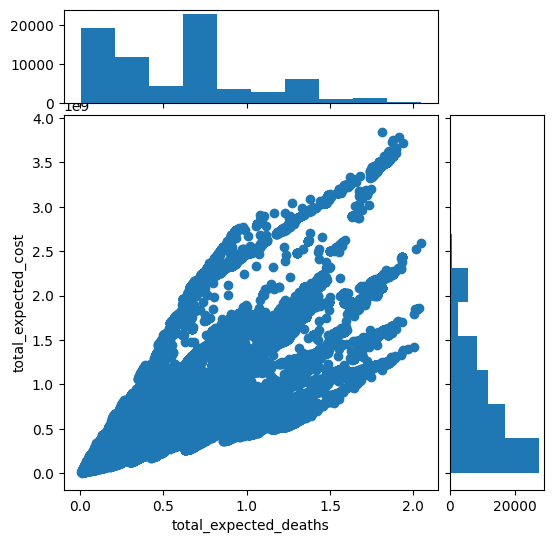

In [5]:
#If done before load results
experiment_name = 'initial_uncertainty_exploration'
pickle_file_folder_path = 'archives/pickle_files/'
path = pickle_file_folder_path + experiment_name + '.pickle'
done_before = os.path.exists(path)

# Policy definition, zero policy
policy_dict = {'0_RfR 0': 0,
               '1_RfR 0': 0,
               '2_RfR 0': 0,
               '3_RfR 0': 0,
               '4_RfR 0': 0,
               'EWS_DaysToThreat': 0,
               'A.1_DikeIncrease 0': 0,
               'A.2_DikeIncrease 0': 0,
               'A.3_DikeIncrease 0': 0,
               'A.4_DikeIncrease 0': 0,
               'A.5_DikeIncrease 0': 0}

if done_before:
    with open(path, 'rb') as file:
        results = pickle.load(file)
else:
    #Do experiments
    scenarios = 2048
    policy = Policy("policy", **policy_dict)

    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(
            scenarios,
            policies=policy,
            uncertainty_sampling=Samplers.SOBOL
        )

    #Save results
    with open(path, 'wb') as file:
        pickle.dump(results, file)

experiments, outcomes = results
df = outcomes_to_df(outcomes)
visualize_scatter(df, 'total_expected_deaths', 'total_expected_cost')

We can see that in some configurations of the uncertainties the total expected deaths can be up to two but in most configurations it is about 0.75 or close to zero. We also observe a peak of total expected deaths between the 0.5 and 1.0 bounds.
The point density that follows the upper bound of total expected cost as total expected deaths increases compared with the point sparsity under it suggests there is some worst case condition resulting in a huge step in total expected cost. It could be that this is the Brate jump from 1.5 to 10.

### Policy exploration
To do a policy exploration we will first select a scenario within which we test all possible policies. With visual inspection of the generated scatter plot we can pick the worst case scenario on the top right. We choose this scenario becouse we emplot robust decision maken, this means we have to consider all posible scenarios and still make an acceptable decision.


In [6]:
worst_outcome = df[
    (df['total_expected_deaths'] > 1.8) &
    (df['total_expected_cost'] > 3800000000)]
worst_case_scenario = experiments.iloc[worst_outcome.index[0]]
worst_case_scenario

A.0_ID flood wave shape            81
A.1_Bmax                   138.194536
A.1_Brate                        10.0
A.1_pfail                    0.324145
A.2_Bmax                   138.863811
A.2_Brate                         1.0
A.2_pfail                    0.030637
A.3_Bmax                    80.623977
A.3_Brate                         1.0
A.3_pfail                    0.070857
A.4_Bmax                    67.904205
A.4_Brate                         1.0
A.4_pfail                    0.834118
A.5_Bmax                   114.144878
A.5_Brate                         1.0
A.5_pfail                    0.451052
discount rate 0                   1.5
0_RfR 0                             0
1_RfR 0                             0
2_RfR 0                             0
3_RfR 0                             0
4_RfR 0                             0
EWS_DaysToThreat                    0
A.1_DikeIncrease 0                  0
A.2_DikeIncrease 0                  0
A.3_DikeIncrease 0                  0
A.4_DikeIncr

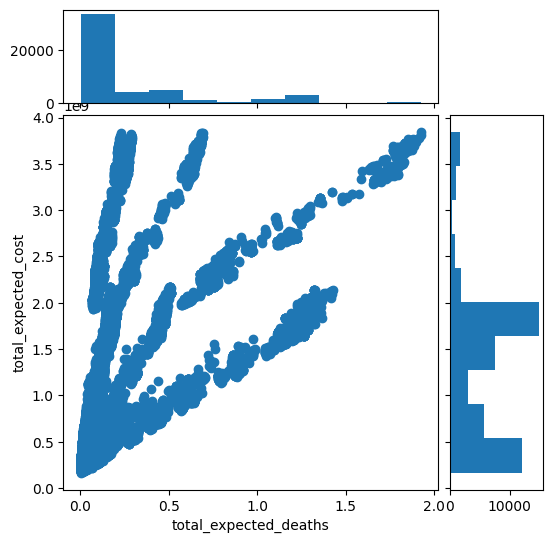

In [7]:
#If done before load results
experiment_name = 'initial_policy_exploration'
pickle_file_folder_path = 'archives/pickle_files/'
path = pickle_file_folder_path + experiment_name + '.pickle'
done_before = os.path.exists(path)

if done_before:
    with open(path, 'rb') as file:
        results = pickle.load(file)
else:
    #Do experiments
    scenario = Scenario('scenario', **dict(worst_case_scenario))
    policy = 2048

    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(
            scenarios=scenario,
            policies=policy,
            lever_sampling=Samplers.SOBOL
        )

    #Save results
    with open(path, 'wb') as file:
        pickle.dump(results, file)

experiments, outcomes = results
df = outcomes_to_df(outcomes)
visualize_scatter(df, 'total_expected_deaths', 'total_expected_cost')

In the policy prim we can see a spike of total expected costs aroind the 1.5 billion mark. And, we can see in both of the explorations that there are lines originating from the origin of the graph. Each line might correspond to a number of dams breaking, or specific combination of dams breaking. To further investigate the scenarios we can use PRIM. This technique will allow us to identify bounds in the uncertainty space withing which certain outcommes are likely to occur.

### Policy space PRIM
We will start with a PRIM where we are intersted in ourcomes with a total expected cost lower than 1.25 billion and less than 0.25 expected deaths. These are disireable outcommes. We will select the point of the prim that have desirable coverage of the clossified cases and density of the clasified cases within the box.

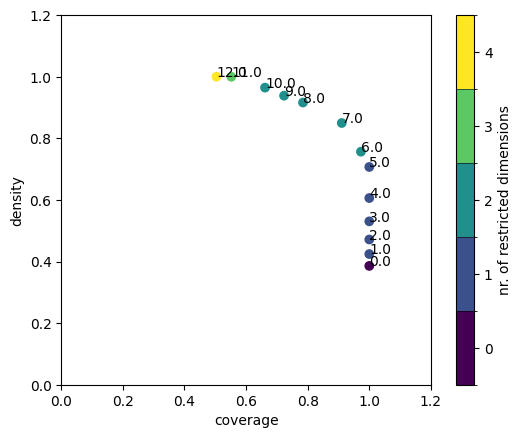

In [8]:
uncertainties = experiments.iloc[:, :17]
outcomes = df.iloc[:, 12:14]
levers = experiments.iloc[:, 17:28]
y = (df['total_expected_cost'] < 1250000000) & (df['total_expected_deaths'] < 0.25)

prim_alg = prim.Prim(levers,
                     y,
                     threshold=0.8,
                     peel_alpha=0.01)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

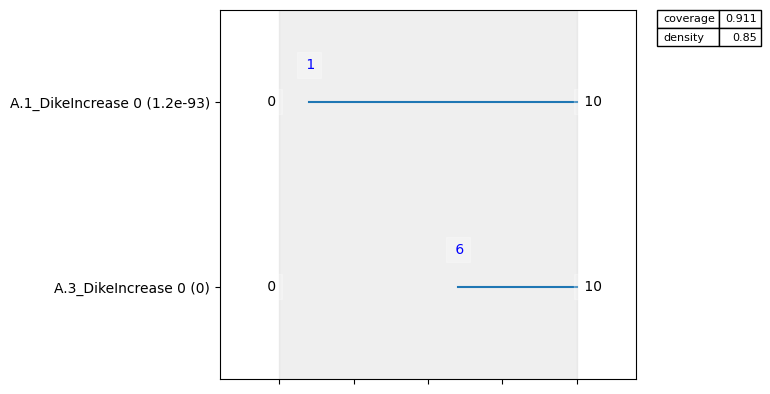

In [9]:
point = 7
box1.inspect(point, style='graph')
plt.show()

To investigate a peak in the policy exploration we will look at a specific range of total expected cost.

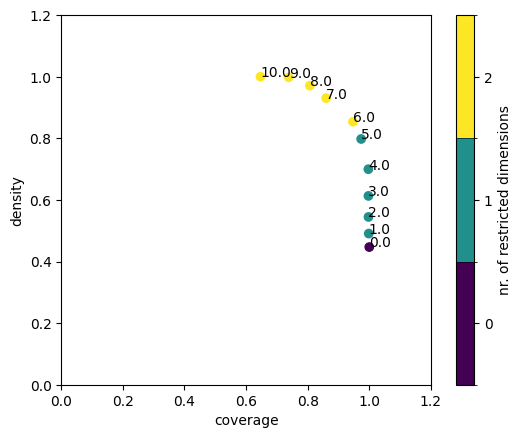

In [10]:
uncertainties = experiments.iloc[:, :17]
outcomes = df.iloc[:, 12:14]
levers = experiments.iloc[:, 17:28]
y = (df['total_expected_cost'] > 1.4e9) & (df['total_expected_cost'] < 2e9)

prim_alg = prim.Prim(levers,
                     y,
                     threshold=0.8,
                     peel_alpha=0.01)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

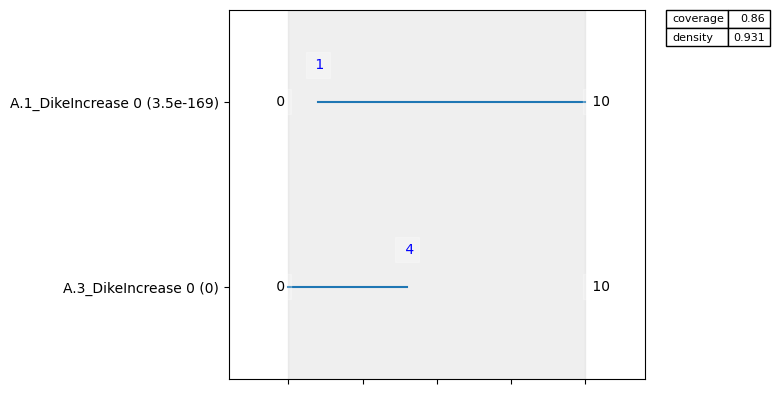

In [11]:
point = 7
box1.inspect(point, style='graph')
plt.show()

### Uncertainty space PRIM
Now that we know what kind of policies will lead to more disrable outcomes in the worst case scenario we will look at what uncertainties lead to worse outcomes. All clasification criteia were based on visual inspection of the scatter plot. First, a PRIM on scenarios resulting in a total expected cost of over one billion. Then, a PRIM on scenarios that lead to more than one expected death. Finally, we will investigate a peak in the scatter plot of uncertainty space exploration.

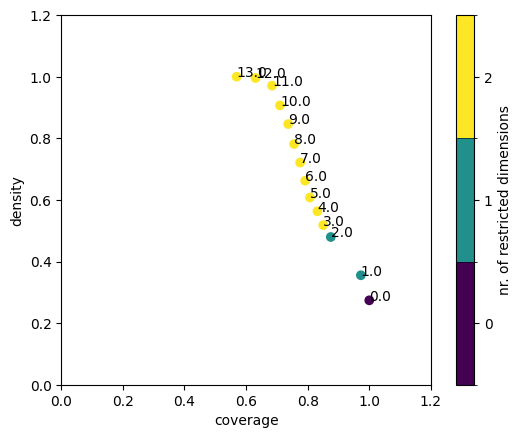

In [12]:
path = 'archives/pickle_files/initial_uncertainty_exploration.pickle'
with open(path, 'rb') as file:
    results = pickle.load(file)
experiments, outcomes = results

df = outcomes_to_df(outcomes)

uncertainties = experiments.iloc[:, :17]
y = (df['total_expected_cost'] > 1000000000)

prim_alg = prim.Prim(uncertainties,
                     y,
                     threshold=0.4,
                     peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

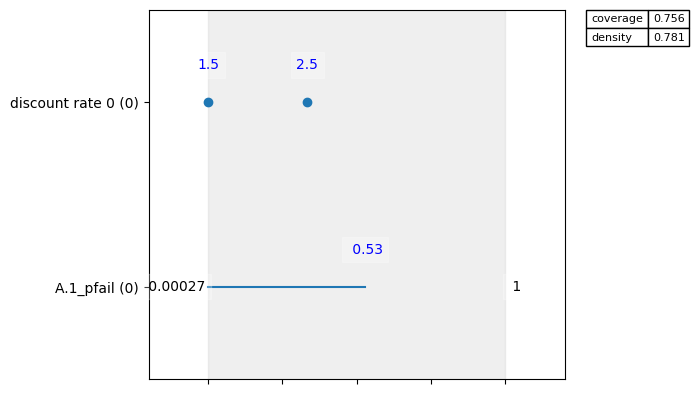

In [13]:
point = 8
box1.inspect(point, style='graph')
plt.show()

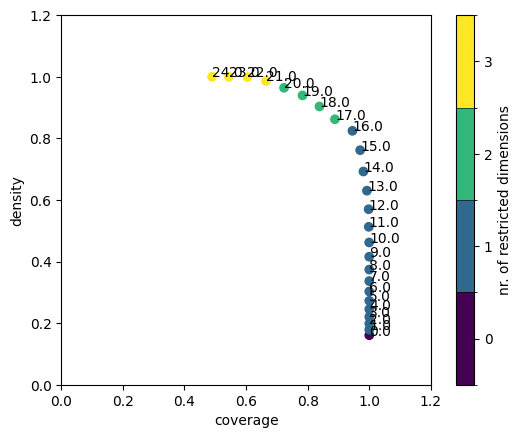

In [16]:
path = 'archives/pickle_files/initial_uncertainty_exploration.pickle'
with open(path, 'rb') as file:
    experiments, outcomes = pickle.load(file)

df = outcomes_to_df(outcomes)

uncertainties = experiments.iloc[:, :17]
y = (df['total_expected_deaths'] > 1)

prim_alg = prim.Prim(uncertainties,
                     y,
                     threshold=0.4,
                     peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

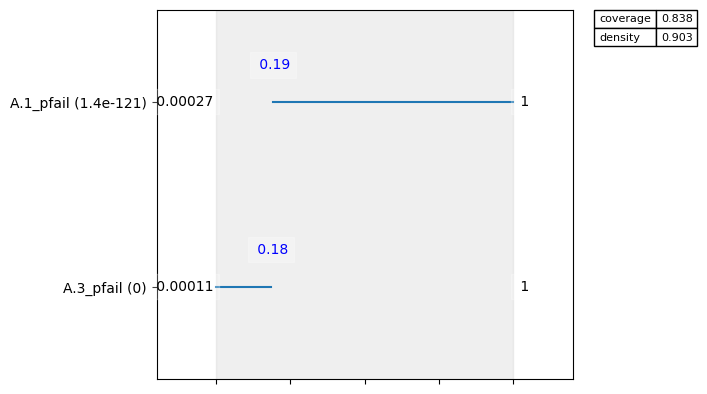

In [17]:
point = 18
box1.inspect(point, style='graph')
plt.show()

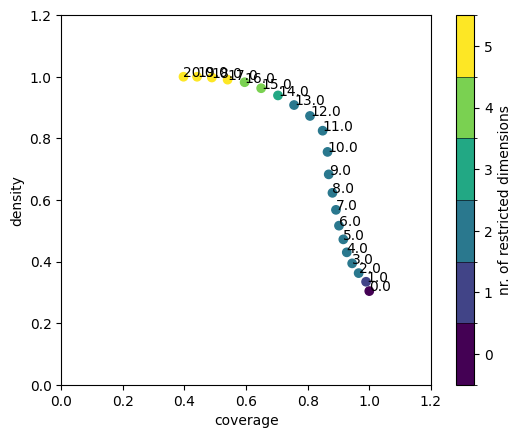

In [14]:
path = 'archives/pickle_files/initial_uncertainty_exploration.pickle'
with open(path, 'rb') as file:
    results = pickle.load(file)
experiments, outcomes = results

df = outcomes_to_df(outcomes)

uncertainties = experiments.iloc[:, :17]
y = (df['total_expected_deaths'] > 0.6) & (df['total_expected_deaths'] < 0.8)

prim_alg = prim.Prim(uncertainties,
                     y,
                     threshold=0.4,
                     peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

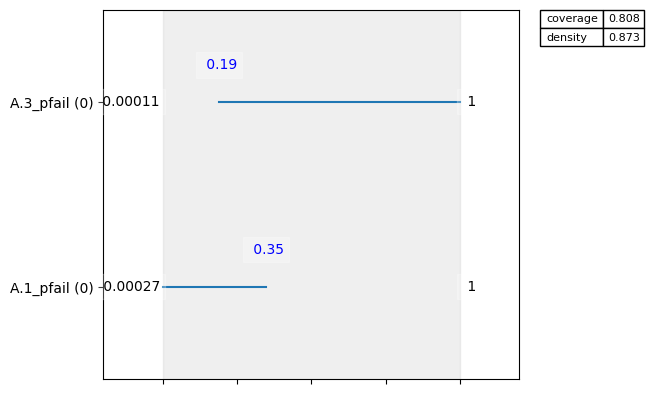

In [15]:
point = 12
box1.inspect(point, style='graph')
plt.show()

### Heatmaps
To further investigate what leads to bad outcomes we will visualize which uncerainties are most important if we look at the worst 10 percent of cases regarding expected deaths, and total expected cost sepperately.

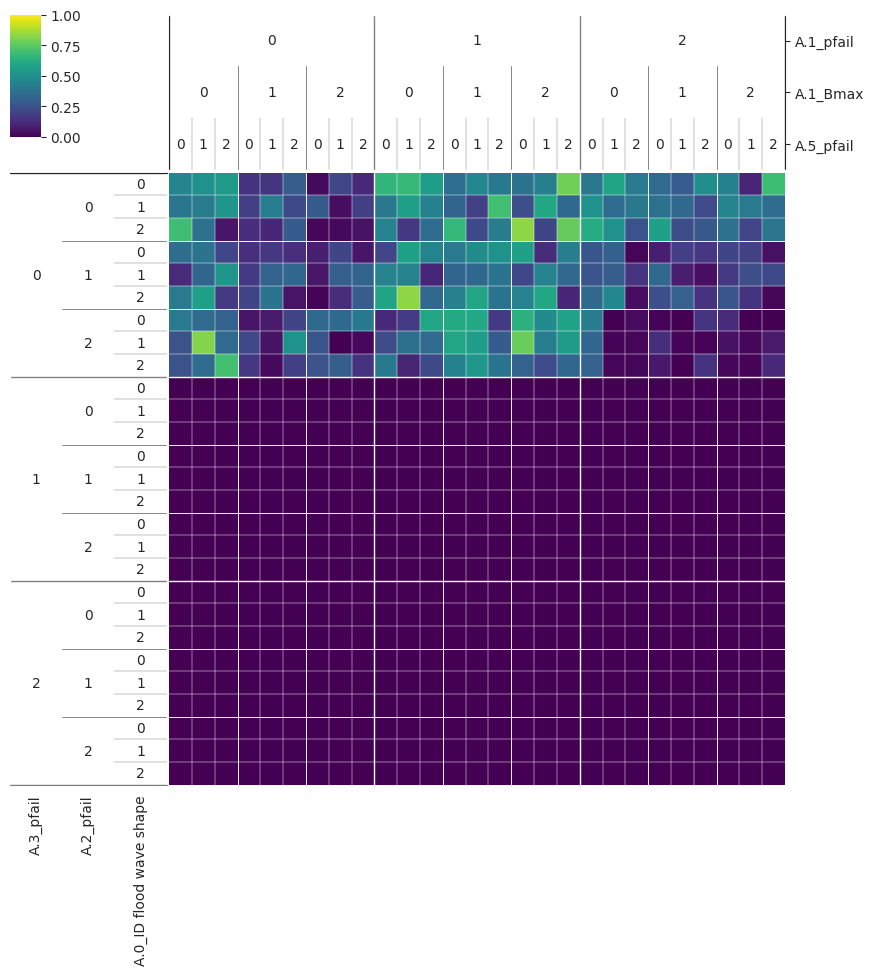

In [18]:
path = 'archives/pickle_files/initial_uncertainty_exploration.pickle'
with open(path, 'rb') as file:
    results = pickle.load(file)
experiments, outcomes = results
cleaned_experiments = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)

df = outcomes_to_df(outcomes)

data = df['total_expected_deaths'].to_numpy()
y = data > np.percentile(data, 90)

dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
pass

We can see that A3_pfail is most important to get into the top ten percent number of expected deaths. This makes sense because dike three protects a city.

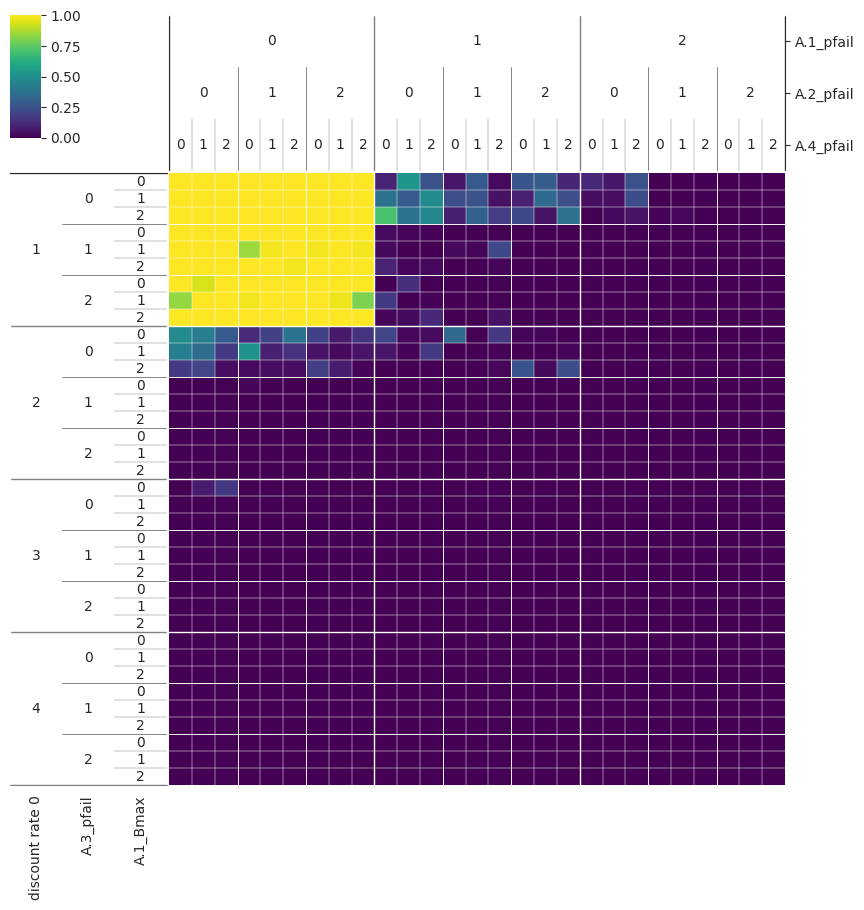

In [19]:
data = df['total_expected_cost'].to_numpy()
y = data > np.percentile(data, 90)

dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
pass

We can see that the top ten percent total cost almost only occurs when there is the lowest discount rate and dike 1 breaks.
### Bar plots
We can also analyze the importance of uncertainties to the outcomes in general with a sensitivity analysis visualized in bar plots. This is also done for deaths and cost sepperatedly.

                               ST   ST_conf
A.0_ID flood wave shape  0.005065  0.001091
A.1_Bmax                 0.012401  0.004190
A.1_Brate                0.000067  0.000035
A.1_pfail                0.567961  0.049253
A.2_Bmax                 0.000830  0.000659
A.2_Brate                0.000012  0.000011
A.2_pfail                0.020755  0.002962
A.3_Bmax                 0.000158  0.000142
A.3_Brate                0.000006  0.000004
A.3_pfail                0.194004  0.015443
A.4_Bmax                 0.000011  0.000009
A.4_Brate                0.000002  0.000001
A.4_pfail                0.000937  0.000323
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.015403  0.003047
discount rate 0          0.337318  0.034329
                               S1   S1_conf
A.0_ID flood wave shape  0.003337  0.004189
A.1_Bmax                 0.006330  0.007138
A.1_Brate                0.000333  0.000333
A.1_pfail                0.45960

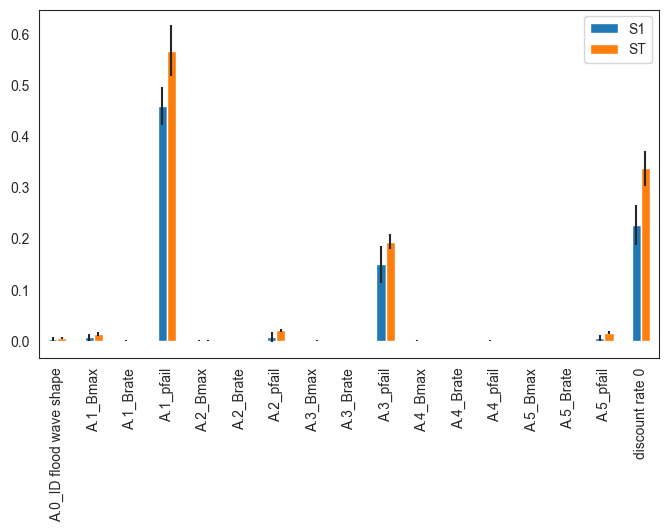

In [20]:
path = 'archives/pickle_files/initial_uncertainty_exploration.pickle'
with open(path, 'rb') as file:
    results = pickle.load(file)
experiments, outcomes = results

df = outcomes_to_df(outcomes)
Y = df['total_expected_cost'].to_numpy()

Si = sobol.analyze(problem, Y, calc_second_order=True, print_to_console=True)
visualize_bar_plot(Si, problem)

                               ST   ST_conf
A.0_ID flood wave shape  0.010215  0.001914
A.1_Bmax                 0.033675  0.010688
A.1_Brate                0.000290  0.000201
A.1_pfail                0.290390  0.021154
A.2_Bmax                 0.003024  0.002712
A.2_Brate                0.000017  0.000009
A.2_pfail                0.033921  0.006675
A.3_Bmax                 0.000095  0.000055
A.3_Brate                0.000007  0.000005
A.3_pfail                0.785273  0.040362
A.4_Bmax                 0.000018  0.000015
A.4_Brate                0.000002  0.000001
A.4_pfail                0.001073  0.000307
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.015357  0.001916
discount rate 0          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.002731  0.005700
A.1_Bmax                 0.014396  0.011079
A.1_Brate                0.000969  0.001341
A.1_pfail                0.18291

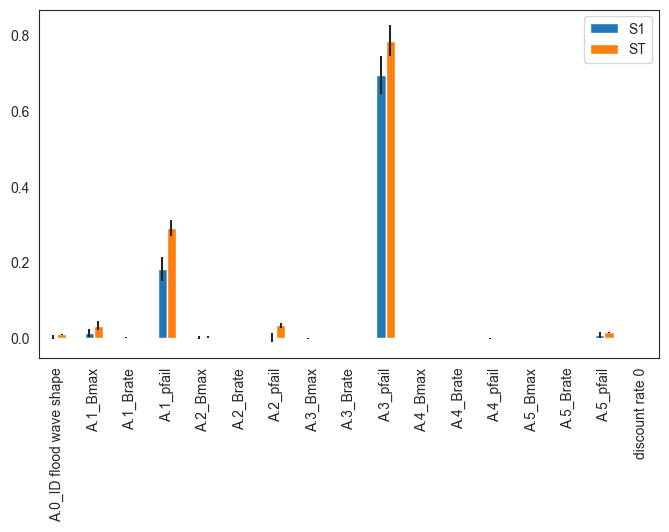

In [21]:
Y = df['total_expected_deaths'].to_numpy()

Si = sobol.analyze(problem, Y, calc_second_order=True, print_to_console=True)
visualize_bar_plot(Si, problem)

We can again confirm that also in general dike 1 is imporatant for cost, and dike 3 for deaths.

### General heatmaps
To get a more specific understanding of these bar plots we can also put it into a heatmap where the parameters sensitivty to infuence results is displayed. For consiseness we will include all uncertainties but sumarize the outcomes for our province and the other province and the total. After seeing that our province has very little effect on the total outcomes we also visualized just the importances fur us and them while disregarding the total picture.

C:\Drive sync\study\Y3\Q4\epa1361_open\venv\Lib\site-packages\sklearn\utils\multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):
C:\Drive sync\study\Y3\Q4\epa1361_open\venv\Lib\site-packages\sklearn\utils\multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):


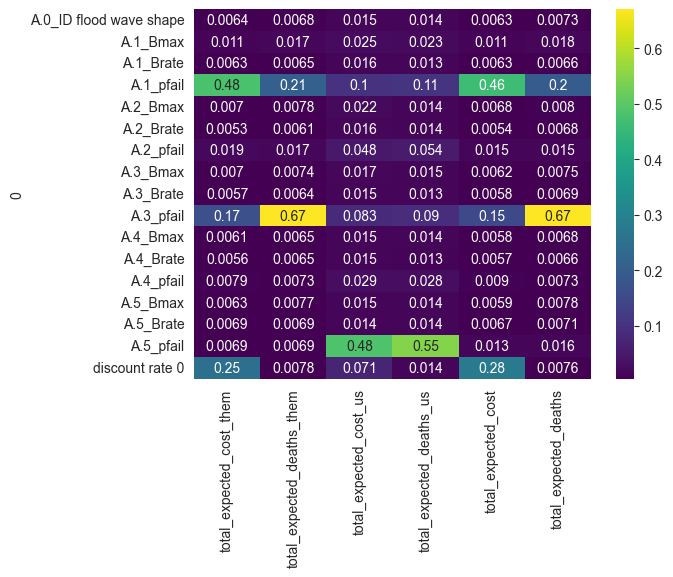

In [22]:
file = 'archives/pickle_files/initial_uncertainty_exploration.pickle'
with open(path, 'rb') as file:
    results = pickle.load(file)
experiments, outcomes = results

outcomes = outcomes_to_df_them_vs_us(outcomes)

visualize_featurescoring_heatmap(experiments, dike_model, outcomes)

C:\Drive sync\study\Y3\Q4\epa1361_open\venv\Lib\site-packages\sklearn\utils\multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):


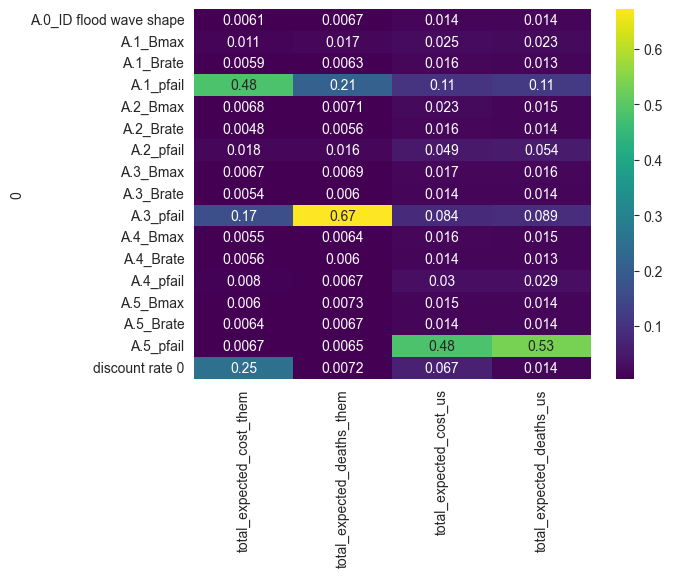

In [23]:
file = 'archives/pickle_files/initial_uncertainty_exploration.pickle'
with open(path, 'rb') as file:
    results = pickle.load(file)
experiments, outcomes = results

outcomes = outcomes_to_df_them_vs_us_only(outcomes)

visualize_featurescoring_heatmap(experiments, dike_model, outcomes)

# Scenario discovery

Scenario reference;
Reference case according to Cuillo et al. (2019)

Scenario 1a:
Reference case, except pfail_A1 is set to 1
PRIM analysis showed a high pfail_A.1 leads to higher expected damages

Scenario 1b:
Reference case, except pfail_A1 is set 0 & pfail_A3 is set to 0
PRIM analysis showed a pfail_A3 between 0-0.18 leads to higher expected damages.
Pfail_A1 is set to 0 as PRIM shows it signficantly impact the system at a value 0.19 or higher. Thus we can measure effects of pfail_A3 alone.

Scenario 1c:
Reference case, except pfail_A1 is 1 and pfail_A3 is 0.
Combination of all unfavourable variables effecting the expected number of deaths significantly according to our PRIM.

Scenario 2:
Reference case, except discount rate is 1.5
PRIM showed a low discount rate strongly influences the expected costs.

Scenario 3:
Reference case, except pfail_A1 is 1, pfail_A3 is 0 and discount rate is 1.5
Combination of scenario 1c and 2, where variables likely to lead highest number of expected deaths and higher costs.